# Tweets Language Classification

## Author: Luis Eduardo Ferro Diez <a href="mailto:luis.ferro1@correo.icesi.edu.co">luis.ferro1@correo.icesi.edu.co</a>

This notebook contains the model training preparation for classifying the tweets language.

## Dataset
* Tweets dataset in parquet format (After executing the first transformation spark pipeline)

## Resources
* https://machinelearningmastery.com/best-practices-document-classification-deep-learning/

### Prepare the data

In [38]:
tweets_path = "../../datasets/tweets_parquet"

In [39]:
import pandas as pd

tweets = pd.read_parquet(tweets_path, engine="pyarrow")

In [40]:
tweets.head()

,id,tweet,lang,favorite_count,retweet_count,is_retweet,user_id,user_name,user_followers_count,user_following_count,...,place_full_name,country,country_code,place_type,place_url,is_spam,year,month,day,hour
0,374048987046637568,@fizziero ngareb beud! !,id,0.0,0.0,0.0,389276837,syarifsidi,47.0,63.0,...,"Jatinegara, Jakarta Timur",Indonesia,ID,city,https://api.twitter.com/1.1/geo/id/9e0e6d510fb...,0.0,2013,9,1,1
1,374048987046625280,"@shahshahrul11 nak buat acano,keto den lg pent...",id,0.0,0.0,0.0,184869610,AliffSadali,194.0,247.0,...,"Keratong, Rompin",Malaysia,MY,city,https://api.twitter.com/1.1/geo/id/1deede127b2...,0.0,2013,9,1,1
2,374048987034419200,@adambeyer234: I already miss Jace like hell,en,0.0,0.0,0.0,363516745,rilez_sharp,582.0,666.0,...,"New York, US",United States,US,admin,https://api.twitter.com/1.1/geo/id/94965b2c453...,0.0,2013,9,1,1
3,374048987050823680,"""this is us""...nunca me voy a artar de verla.....",es,0.0,0.0,0.0,446125189,LUCRECIALg,13.0,65.0,...,Argentina,Argentina,AR,country,https://api.twitter.com/1.1/geo/id/4d3b316fe2e...,0.0,2013,9,1,1
4,374048991241310208,Aquí en una reunión casual (@ Dhamy's Bar) [pi...,es,0.0,0.0,0.0,44793849,charal3x,66.0,77.0,...,"Veracruz, Veracruz de Ignacio de la Llave",México,MX,city,https://api.twitter.com/1.1/geo/id/6c67fe933a6...,0.0,2013,9,1,1


We consider the most relevant parts to predict the tweet language to be:
* The tweet text
* The country code

The tweet text might contain user mentions, for simplicity, we will first transform the text, replacing the user mention with the text "@usermention".

In [41]:
import re

tweets.tweet = tweets.tweet.apply(lambda x: re.sub(r"@[\w\d]+", "@usermention", x))
tweets = tweets[["tweet", "country_code", "lang"]]
tweets.head()

,tweet,country_code,lang
0,@usermention ngareb beud! !,ID,id
1,"@usermention nak buat acano,keto den lg pentin...",MY,id
2,@usermention: I already miss Jace like hell,US,en
3,"""this is us""...nunca me voy a artar de verla.....",AR,es
4,Aquí en una reunión casual (@ Dhamy's Bar) [pi...,MX,es


Now let's convert the country code into a onehot encoding

In [69]:
tweets.country_code.unique()

array(['ID', 'MY', 'US', 'AR', 'MX', 'GB', 'RU', 'CL', 'JP', 'BR', 'CA',
       'TR', 'PH', 'FR', 'IT', 'NL', 'ES', 'DE', 'NO', 'ZA'], dtype=object)

In [90]:
from sklearn.preprocessing import LabelEncoder

country_encoder = LabelEncoder()
country_encoded = country_encoder.fit_transform(tweets.country_code.values).reshape(-1, 1)

Now, we'll encode the target class, i.e., the language

In [71]:
tweets.lang.unique()

array(['id', 'en', 'es', 'ru', 'pt', 'ja', 'tr', 'nl', 'tl', 'bg', 'und',
       'vi', 'sl', 'it', 'fr', 'no', 'et', 'lv'], dtype=object)

In [91]:
language_encoder = LabelEncoder()
language_encoded = language_encoder.fit_transform(tweets.lang.values).reshape(-1, 1)

With this information we'll create embeddings to train a CNN + Fully Connected ANN to predict the language.

Also for testing, we are going to use a LTSM + Fully Connected ANN and compare the results.

Since we are dealing with two types of features, we'll need to prepare a bidirectional NN

First, let's prepare the embeddings using the tweet text

In [74]:
from keras.preprocessing.text import Tokenizer

words = 1000
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(tweets.tweet)
print(f"Unique tokens: {len(tokenizer.word_index)}")
tokenizer.word_index

Unique tokens: 985


{'usermention': 1,
 't': 2,
 'co': 3,
 'http': 4,
 'i': 5,
 'to': 6,
 'the': 7,
 'a': 8,
 'at': 9,
 'me': 10,
 'you': 11,
 'and': 12,
 '—': 13,
 'https': 14,
 'with': 15,
 'in': 16,
 'of': 17,
 'my': 18,
 "i'm": 19,
 'lagi': 20,
 'for': 21,
 'is': 22,
 'be': 23,
 'it': 24,
 'this': 25,
 '0': 26,
 'rt': 27,
 'de': 28,
 'pic': 29,
 'that': 30,
 'lol': 31,
 'so': 32,
 'but': 33,
 'on': 34,
 'by': 35,
 'p': 36,
 'ini': 37,
 'she': 38,
 'all': 39,
 'd': 40,
 'im': 41,
 '3': 42,
 'up': 43,
 'go': 44,
 'should': 45,
 'when': 46,
 'home': 47,
 "don't": 48,
 'others': 49,
 'nak': 50,
 '4': 51,
 'today': 52,
 'love': 53,
 'u': 54,
 'do': 55,
 'amp': 56,
 'tau': 57,
 'yuk': 58,
 'tu': 59,
 'yg': 60,
 'now': 61,
 'hahaha': 62,
 'text': 63,
 'school': 64,
 'your': 65,
 'night': 66,
 'come': 67,
 'off': 68,
 'x': 69,
 'mie': 70,
 'work': 71,
 'hard': 72,
 'dan': 73,
 'gue': 74,
 'out': 75,
 '“': 76,
 'jadi': 77,
 'been': 78,
 'yup': 79,
 'hoes': 80,
 'kenapa': 81,
 'have': 82,
 'no': 83,
 'ada': 84,

In [109]:
from keras.preprocessing.sequence import pad_sequences

MAX_TEXT_SEQ_LEN = 280
tweet_sequences = np.array(tokenizer.texts_to_sequences(tweets.tweet))
tweet_sequences = pad_sequences(tweet_sequences, MAX_TEXT_SEQ_LEN)

`tweet_sequences` contains the indexed text strings which are going to be the input for the NN.

Now, let's assemble everything and prepare the train and test sets.

In [193]:
from sklearn.model_selection import train_test_split

X = tweet_sequences
X_c = country_encoded
y = language_encoded

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train_c, X_test_c, _, _ = train_test_split(X_c, y, test_size=0.2, random_state=1234)

Now, let's define the model

In [208]:
from keras.layers import Input, Embedding, Bidirectional, Dense, LSTM, concatenate, BatchNormalization, Dropout
from keras.models import Model
from keras import regularizers

#Define the inputs
tweet_input = Input(shape=(MAX_TEXT_SEQ_LEN,), dtype='int32', name='tweet_text')
country_input = Input(shape=(1,), name='country_input')

#Define the embedding layer consuming the tweet input
emb = Embedding(input_dim=tokenizer.num_words, output_dim=64, input_length=MAX_TEXT_SEQ_LEN)(tweet_input)

#Define the LSTM layer with the embedding input
tweet_output = Bidirectional(
        LSTM(units=30, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01))
    )(emb)

#Define an auxiliary output for the first input
aux_output = Dense(tweets.lang.unique().shape[0], activation='softmax', name='aux_output')(tweet_output)

#Concatenate the LSTM output with the country input
x = concatenate([tweet_output, country_input])

#Apply a dense layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(25, activation='relu')(x)

#And finally make the predictions using the previous layer as input
main_output = Dense(tweets.lang.unique().shape[0], activation='softmax', name='prediction')(x)

model = Model(inputs=[tweet_input, country_input], outputs=[main_output, aux_output])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tweet_text (InputLayer)         (None, 280)          0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, 280, 64)      64000       tweet_text[0][0]                 
__________________________________________________________________________________________________
bidirectional_25 (Bidirectional (None, 60)           22800       embedding_38[0][0]               
__________________________________________________________________________________________________
country_input (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
concatenat

In [209]:
%%time
train_data = [X_train, X_train_c]
history = model.fit(train_data, [y_train] * 2, epochs = 100, batch_size = 5, validation_split= 0.2)

Train on 118 samples, validate on 30 samples
Epoch 1/100
118/118 [==============================] - 13s 110ms/step - loss: 7.0229 - prediction_loss: 2.7814 - aux_output_loss: 2.8339 - prediction_acc: 0.1356 - aux_output_acc: 0.3475 - val_loss: 6.4233 - val_prediction_loss: 2.5366 - val_aux_output_loss: 2.7326 - val_prediction_acc: 0.1333 - val_aux_output_acc: 0.5000
Epoch 2/100
118/118 [==============================] - 8s 70ms/step - loss: 5.8854 - prediction_loss: 2.3314 - aux_output_loss: 2.5786 - prediction_acc: 0.2373 - aux_output_acc: 0.4915 - val_loss: 5.1499 - val_prediction_loss: 2.0075 - val_aux_output_loss: 2.3420 - val_prediction_acc: 0.5667 - val_aux_output_acc: 0.5000
Epoch 3/100
118/118 [==============================] - 8s 69ms/step - loss: 4.6523 - prediction_loss: 1.9787 - aux_output_loss: 1.9888 - prediction_acc: 0.5169 - aux_output_acc: 0.4915 - val_loss: 4.3070 - val_prediction_loss: 1.8554 - val_aux_output_loss: 1.8805 - val_prediction_acc: 0.5667 - val_aux_output

118/118 [==============================] - 8s 69ms/step - loss: 1.7683 - prediction_loss: 0.7675 - aux_output_loss: 0.8503 - prediction_acc: 0.7627 - aux_output_acc: 0.7627 - val_loss: 2.8658 - val_prediction_loss: 1.2604 - val_aux_output_loss: 1.4536 - val_prediction_acc: 0.6667 - val_aux_output_acc: 0.6000
Epoch 27/100
118/118 [==============================] - 8s 70ms/step - loss: 1.6026 - prediction_loss: 0.6169 - aux_output_loss: 0.8340 - prediction_acc: 0.8220 - aux_output_acc: 0.7881 - val_loss: 2.8267 - val_prediction_loss: 1.2394 - val_aux_output_loss: 1.4371 - val_prediction_acc: 0.7000 - val_aux_output_acc: 0.6000
Epoch 28/100
118/118 [==============================] - 8s 69ms/step - loss: 1.6573 - prediction_loss: 0.7007 - aux_output_loss: 0.8078 - prediction_acc: 0.7881 - aux_output_acc: 0.7966 - val_loss: 2.8158 - val_prediction_loss: 1.2406 - val_aux_output_loss: 1.4277 - val_prediction_acc: 0.6333 - val_aux_output_acc: 0.6000
Epoch 29/100
118/118 [======================

118/118 [==============================] - 8s 69ms/step - loss: 1.2360 - prediction_loss: 0.4766 - aux_output_loss: 0.6484 - prediction_acc: 0.8136 - aux_output_acc: 0.8051 - val_loss: 2.9415 - val_prediction_loss: 1.3073 - val_aux_output_loss: 1.5218 - val_prediction_acc: 0.7333 - val_aux_output_acc: 0.5667
Epoch 52/100
118/118 [==============================] - 8s 68ms/step - loss: 1.1321 - prediction_loss: 0.4236 - aux_output_loss: 0.5959 - prediction_acc: 0.8390 - aux_output_acc: 0.8220 - val_loss: 2.8768 - val_prediction_loss: 1.2605 - val_aux_output_loss: 1.5045 - val_prediction_acc: 0.7000 - val_aux_output_acc: 0.5667
Epoch 53/100
118/118 [==============================] - 8s 68ms/step - loss: 1.1686 - prediction_loss: 0.4470 - aux_output_loss: 0.6086 - prediction_acc: 0.8559 - aux_output_acc: 0.8220 - val_loss: 3.0096 - val_prediction_loss: 1.3732 - val_aux_output_loss: 1.5202 - val_prediction_acc: 0.7000 - val_aux_output_acc: 0.5667
Epoch 54/100
118/118 [======================

118/118 [==============================] - 8s 71ms/step - loss: 0.8515 - prediction_loss: 0.2809 - aux_output_loss: 0.4622 - prediction_acc: 0.8898 - aux_output_acc: 0.8644 - val_loss: 3.4759 - val_prediction_loss: 1.7299 - val_aux_output_loss: 1.6385 - val_prediction_acc: 0.6000 - val_aux_output_acc: 0.5333
Epoch 77/100
118/118 [==============================] - 8s 67ms/step - loss: 0.8912 - prediction_loss: 0.3307 - aux_output_loss: 0.4533 - prediction_acc: 0.9068 - aux_output_acc: 0.8644 - val_loss: 3.4897 - val_prediction_loss: 1.7066 - val_aux_output_loss: 1.6773 - val_prediction_acc: 0.6333 - val_aux_output_acc: 0.5333
Epoch 78/100
118/118 [==============================] - 8s 68ms/step - loss: 0.9336 - prediction_loss: 0.3888 - aux_output_loss: 0.4397 - prediction_acc: 0.8729 - aux_output_acc: 0.8644 - val_loss: 3.5644 - val_prediction_loss: 1.7489 - val_aux_output_loss: 1.7102 - val_prediction_acc: 0.5667 - val_aux_output_acc: 0.5000
Epoch 79/100
118/118 [======================

In [198]:
import matplotlib.pyplot as plt

def plot_history(cnn, acc= 'acc', val_acc = 'val_acc', loss = 'loss', val_loss = 'val_loss'):
    fig = plt.figure(figsize = (16, 8))
    plt.subplot(1, 2, 1)
    plt.title('Accuracy in training Vs validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.plot(cnn.history[acc], 'r')
    plt.plot(cnn.history[val_acc], 'b')
    plt.legend(['training', 'validation'])
    
    plt.subplot(1, 2, 2)
    plt.title('Loss in training Vs validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.plot(cnn.history[loss], 'r')
    plt.plot(cnn.history[val_loss], 'b')
    plt.legend(['training', 'validation'])
    
    plt.show()
    

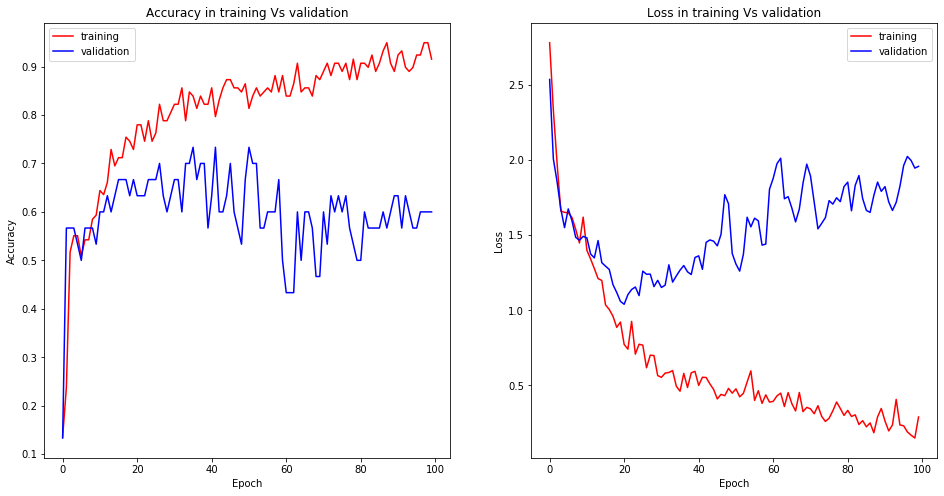

In [210]:
plot_history(history, 
             acc='prediction_acc', 
             val_acc='val_prediction_acc', 
             loss='prediction_loss', 
             val_loss='val_prediction_loss')